In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load historical data for EA and Take-Two

In [2]:
EA = yf.download('EA', start='2001-01-01', end='2022-12-31', progress=False)
TT = yf.download('TTWO', start='2001-01-01', end='2022-12-31', progress=False)

# Extract adjusted closing prices

In [3]:
x = EA['Adj Close'].values
y = TT['Adj Close'].values

# Calculating the dynamically changing hedge ratio

In [4]:
lookback = 20
hedgeRatio = np.empty_like(x)
hedgeRatio[:] = np.nan

for t in range(lookback, len(hedgeRatio)):
    y_slice = y[t - lookback:t]
    x_slice = x[t - lookback:t]
    ones_column = np.ones(lookback)
    X = np.column_stack((x_slice, ones_column))
    regression_result = np.linalg.lstsq(X, y_slice, rcond=None)
    hedgeRatio[t] = regression_result[0][0]

y2 = np.column_stack((x, y))
yport = np.sum(np.column_stack((-hedgeRatio, np.ones_like(hedgeRatio))) * y2, axis=1)

# Calculate the number of units to own

In [5]:
numUnits = -(yport - pd.Series(yport).rolling(window=lookback).mean()) / pd.Series(yport).rolling(window=lookback).std()
numUnits_expanded = np.column_stack((numUnits, numUnits))

# Calculate the market value of each stock to invest

In [6]:
positions = numUnits_expanded * np.column_stack((-hedgeRatio, np.ones_like(hedgeRatio))) * y2

positions = pd.DataFrame(positions, columns=['EA_Position', 'TT_Position'])
positions['Date'] = EA.index
positions.set_index('Date', inplace=True)

# Calculate daily P&L of the strategy

In [7]:
lagged_y2 = np.roll(y2, 1, axis=0)
lagged_y2[0] = 0  # Set the first row to 0 for the initial value
pnl = np.sum(positions * (y2 - lagged_y2) / lagged_y2, axis=1)

ret = pnl / np.sum(np.abs(positions), axis=1)
ret[np.isnan(ret)] = 0

# Calculate APR and Sharpe Ratio

In [8]:
annualized_ret = np.prod(1 + ret) ** (252 / len(ret)) - 1    # On average, there are 252 trading days in USA
sharpe_ratio = np.sqrt(252) * np.mean(ret) / np.std(ret)

print(f'APR = {annualized_ret:.6f}, Sharpe = {sharpe_ratio:.6f}')

APR = -0.269741, Sharpe = -0.846080


# Plot time series of return

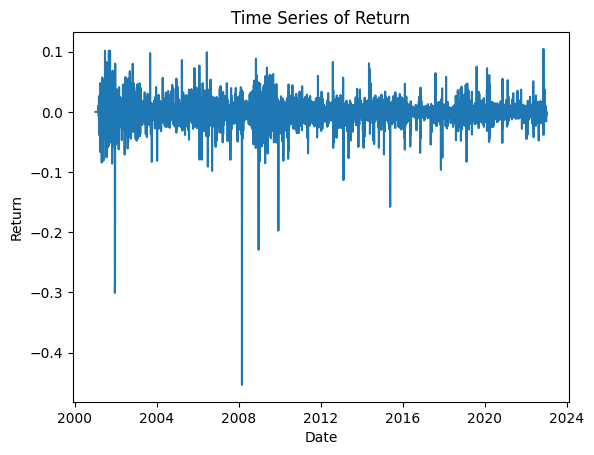

In [9]:
plt.figure()
plt.plot(ret)
plt.title('Time Series of Return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

# Plot cumulative compounded return

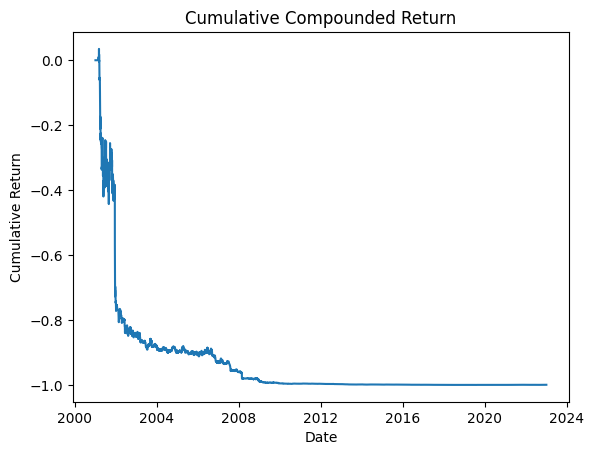

In [10]:
cumulative_ret = np.cumprod(1 + ret) - 1
plt.figure()
plt.plot(cumulative_ret)
plt.title('Cumulative Compounded Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

# Reversed Strategy - Long when overvalued. Short when undervalued.

In [11]:
numUnits = (yport - pd.Series(yport).rolling(window=lookback).mean()) / pd.Series(yport).rolling(window=lookback).std()
numUnits_expanded = np.column_stack((numUnits, numUnits))
positions = numUnits_expanded * np.column_stack((-hedgeRatio, np.ones_like(hedgeRatio))) * y2

positions = pd.DataFrame(positions, columns=['EA_Position', 'TT_Position'])
positions['Date'] = EA.index
positions.set_index('Date', inplace=True)

pnl = np.sum(positions * (y2 - lagged_y2) / lagged_y2, axis=1)
ret = pnl / np.sum(np.abs(positions), axis=1)
ret[np.isnan(ret)] = 0

# Calculate APR and Sharpe Ratio

In [12]:
annualized_ret = np.prod(1 + ret) ** (252 / len(ret)) - 1
sharpe_ratio = np.sqrt(252) * np.mean(ret) / np.std(ret)

print(f'APR = {annualized_ret:.6f}, Sharpe = {sharpe_ratio:.6f}')

APR = 0.241369, Sharpe = 0.846080


# Plot time series of return

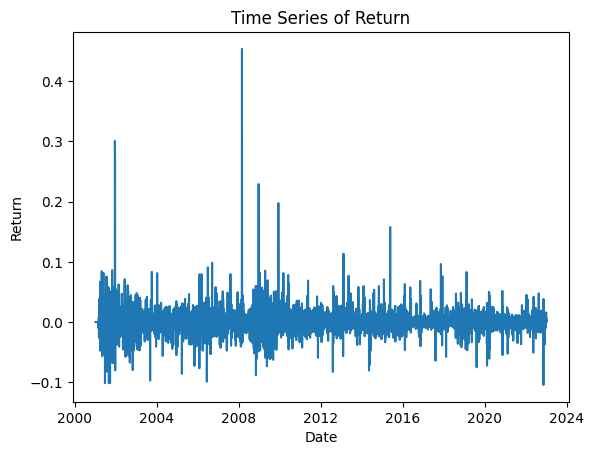

In [13]:
plt.figure()
plt.plot(ret)
plt.title('Time Series of Return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

# Plot cumulative compounded return

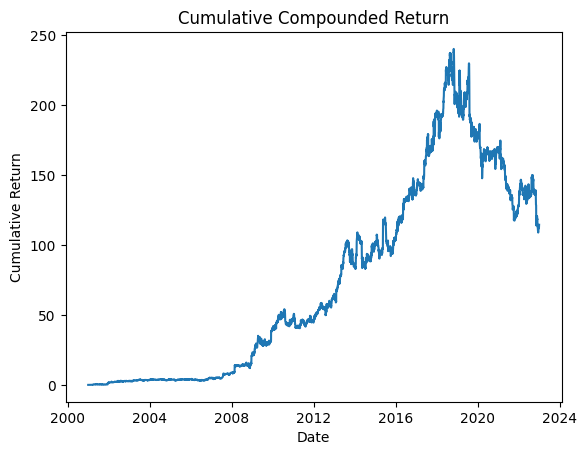

In [14]:
cumulative_ret = np.cumprod(1 + ret) - 1
plt.figure()
plt.plot(cumulative_ret)
plt.title('Cumulative Compounded Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()